## Set up environment

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score

# Regression

## Load data

CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS proportion of non-retail business acres per town

CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT % lower status of the population

MEDV Median value of owner-occupied homes in $1000’s (TARGET)

In [37]:
X = pd.DataFrame(load_boston()['data'])
y = pd.DataFrame(load_boston()['target'])

X.columns = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b1000', 'lstat']
y.columns = ['medv']

boston = pd.concat([X, y], axis=1)

X = X.values
y = y.values.ravel()

In [38]:
boston.shape

(506, 14)

In [39]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b1000,lstat,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


These are all numerical features. If there were categorical features, we would need to encode them as dummies (see `pd.get_dummies()`).

## EDA

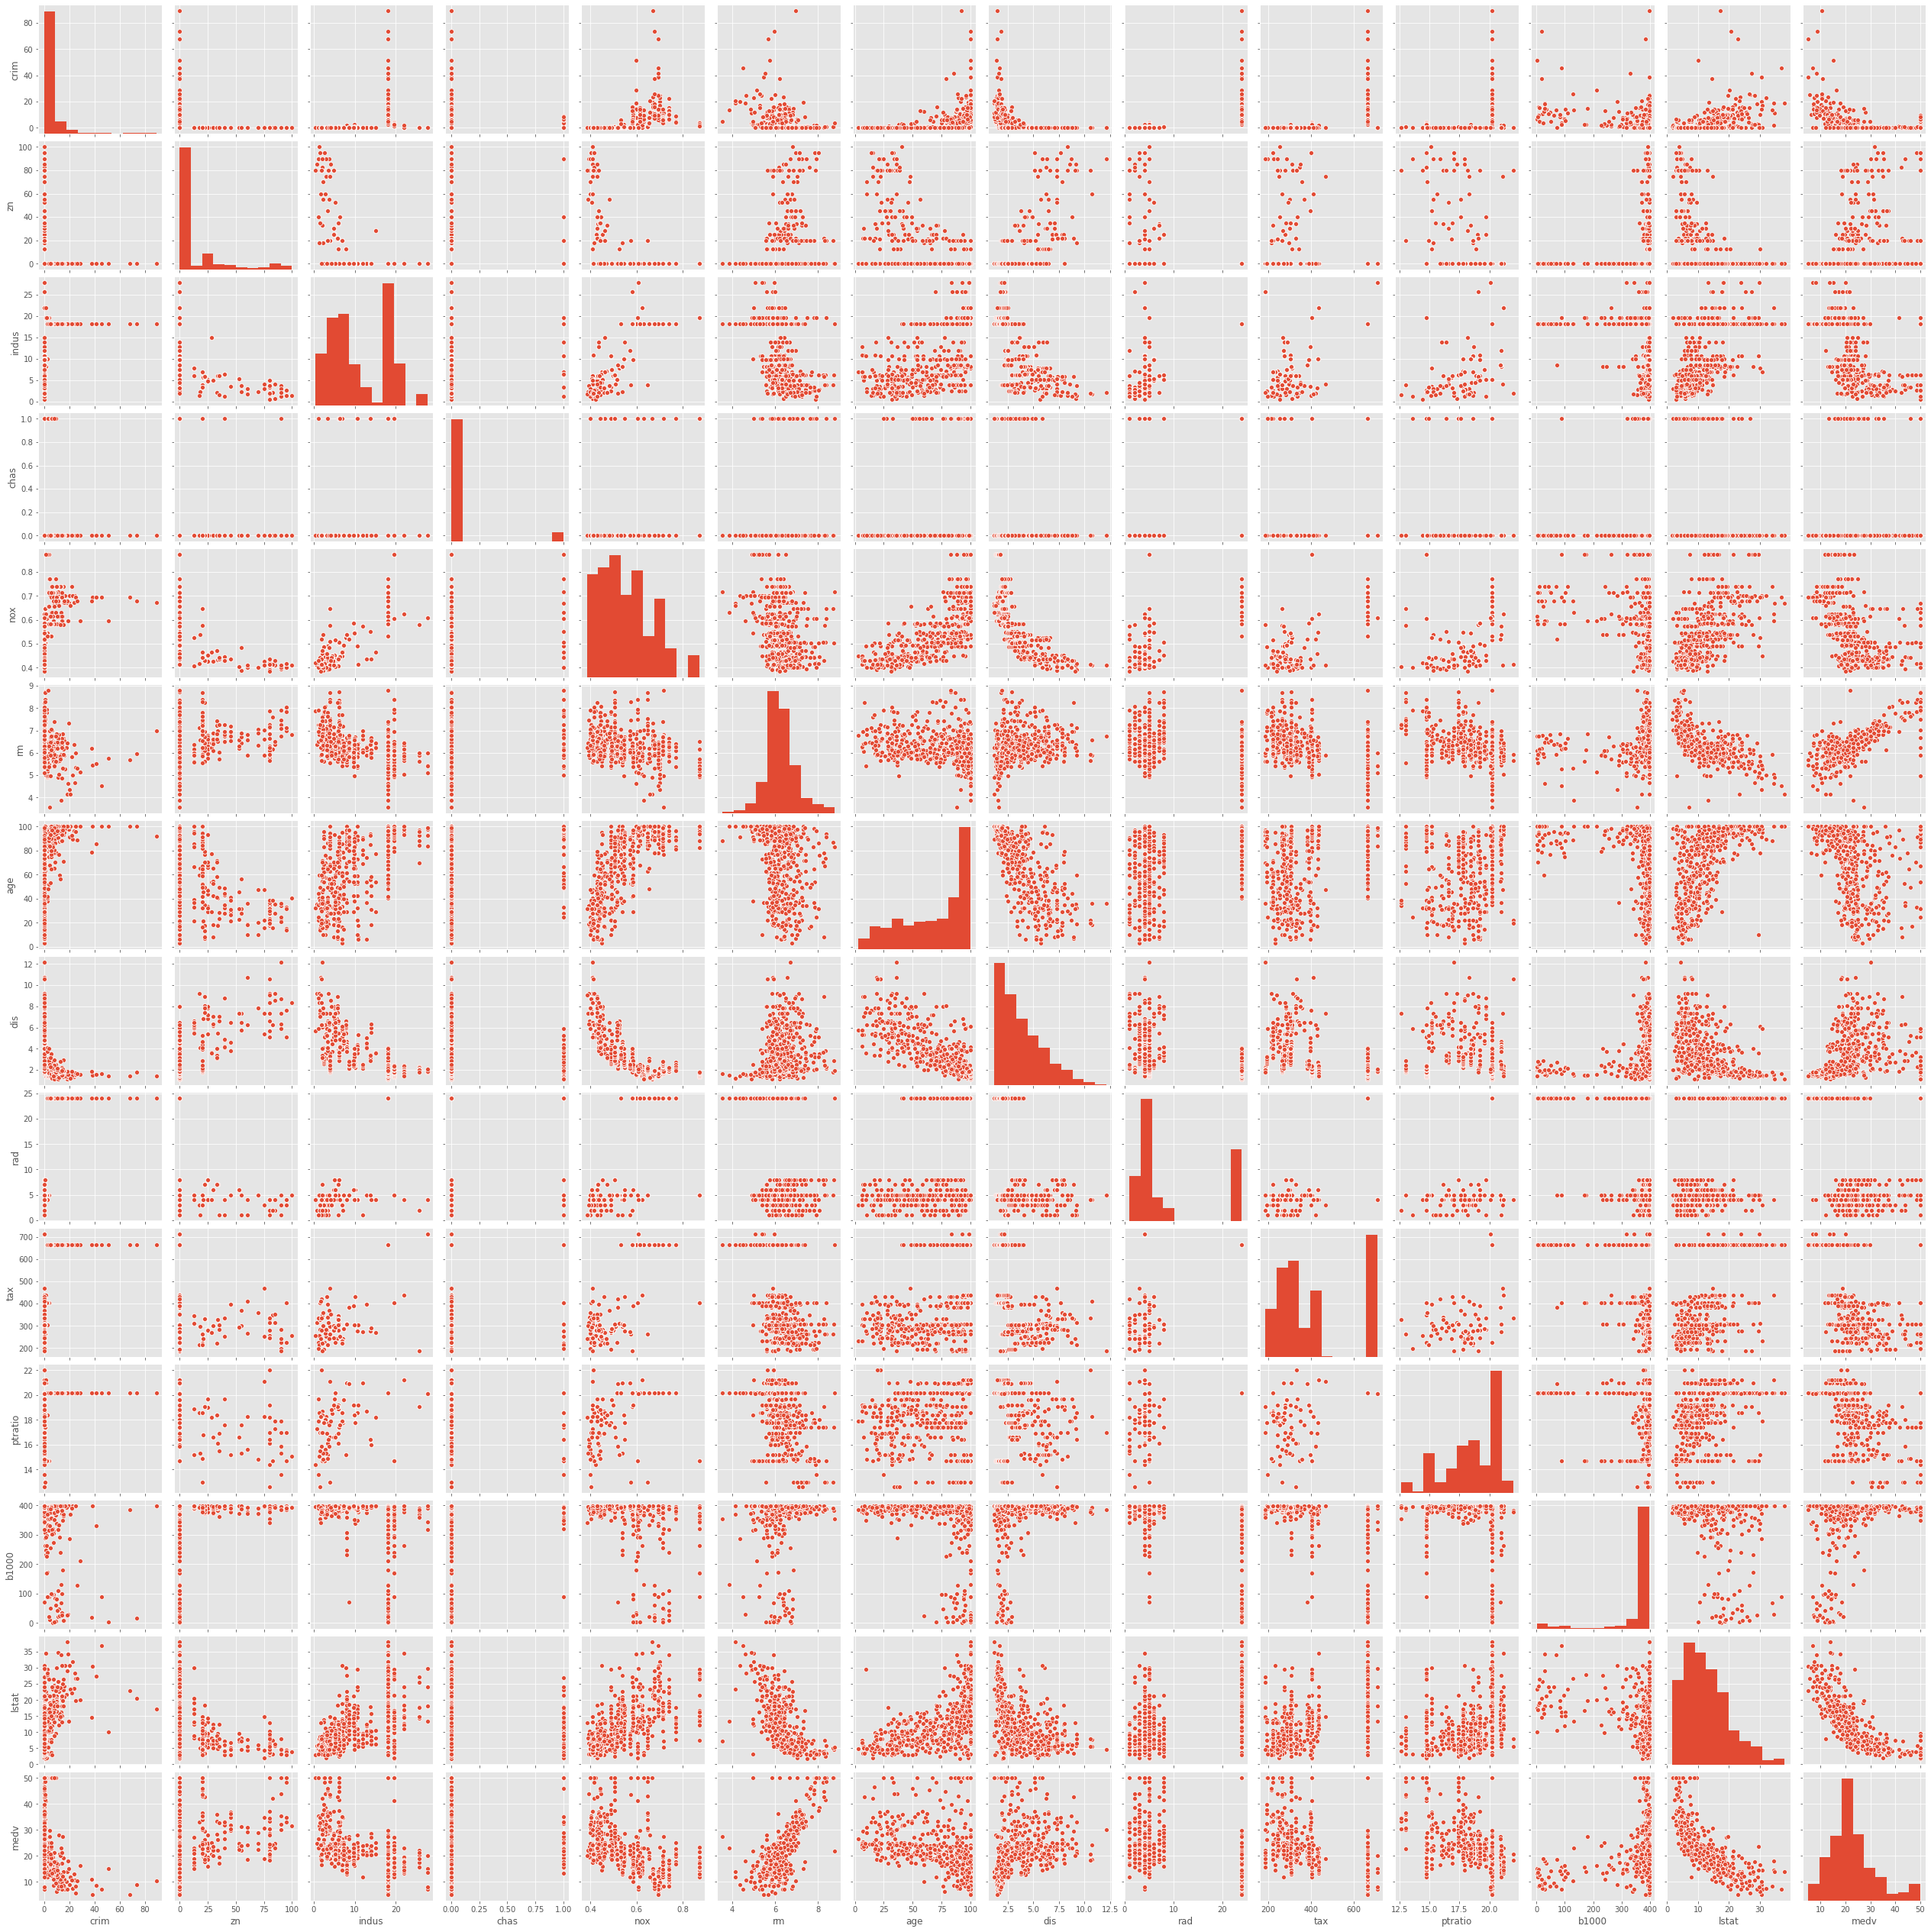

In [5]:
sns.pairplot(boston)

<AxesSubplot:>

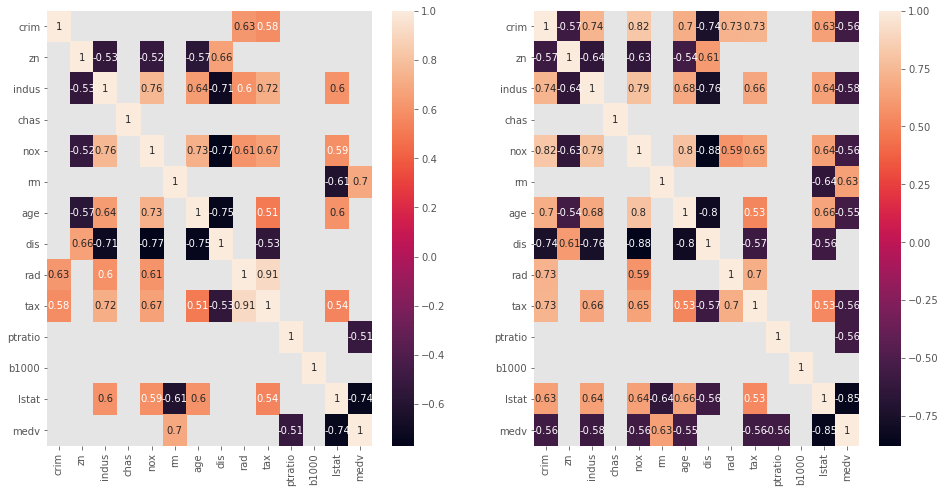

In [6]:
p_corr = boston.corr()
s_corr = boston.corr(method='spearman')

fig, ax = plt.subplots(1, 2, figsize=(16,8))

sns.heatmap(p_corr, annot=True, mask=(p_corr < 0.5) & (p_corr > -0.5), ax=ax[0])
sns.heatmap(s_corr, annot=True, mask=(s_corr < 0.5) & (s_corr > -0.5), ax=ax[1])

At this stage in the real world we would do a lot more EDA. The main things we'd look out for are:
- Outliers
- Missing data
- Relationship among predictors (features in X)
- Relationship between predictors and target
- Based on the above, engineer new features that contain valuable information to help the model predict more accurately

## Modelling

### The wrong way

Instantiate the model

In [40]:
lr = LinearRegression()

Fit model

In [41]:
lr.fit(X, y)

LinearRegression()

Store predictions

In [42]:
preds = lr.predict(X)

Evaluate model

In [43]:
r2_score(y_true=y, y_pred=preds)

0.7406426641094095

In [44]:
mean_squared_error(y_true=y, y_pred=preds)

21.894831181729202

### The right way

With train-test split

In [45]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(506, 13)
(506,)
(404, 13)
(102, 13)
(404,)
(102,)


Fit model on the training set

In [46]:
lr.fit(X_train, y_train)

LinearRegression()

Predict on the test set

In [47]:
preds = lr.predict(X_test)

Evaluate model on test set

In [48]:
r2_score(y_true=y_test, y_pred=preds)

0.6592466510354097

In [49]:
mean_squared_error(y_true=y_test, y_pred=preds)

28.192485758469548

Or using cross-validation

In [50]:
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=KFold(n_splits=5))
scores

array([-12.46030057, -26.04862111, -33.07413798, -80.76237112,
       -33.31360656])

In [51]:
-np.mean(scores)

37.13180746769922

Note that the mean squared errors are bigger (worse) than before! Always validate on a holdout dataset.

#### A more complex model

Support Vector Machine

In [52]:
svr = SVR()

In [54]:
-np.mean(cross_val_score(svr, X, y, scoring='neg_mean_squared_error', cv=KFold(n_splits=5)))

71.85800739156483

This model is much worse... Let's try tuning some of its hyperparameters

In [55]:
params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

In [56]:
grid = GridSearchCV(svr, params, scoring='neg_mean_squared_error', cv=KFold(n_splits=3))

In [57]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [58]:
grid.best_estimator_

SVR(C=10, kernel='linear')

We can also see the best score of the inner cross-validation loop

In [59]:
-grid.best_score_

23.776670279375967

But we shouldn't do this! We should always validate on a holdout (test) set

In [60]:
# like this
preds = grid.best_estimator_.predict(X_test)

mean_squared_error(y_true=y_test, y_pred=preds)

32.793562366886

In [61]:
# or like this
-np.mean(cross_val_score(grid, X, y, scoring='neg_mean_squared_error', cv=5))

38.4979525921229

Much better!

Another example: Random Forest

In [62]:
rfr = RandomForestRegressor()

In [63]:
-np.mean(cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=KFold(n_splits=5)))

21.77682508569208

This model a bit better. Let's try tuning some of its hyperparameters

In [102]:
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 4, 8]
}

In [103]:
grid = GridSearchCV(rfr, params, scoring='neg_mean_squared_error', cv=KFold(n_splits=3))

In [112]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [113]:
grid.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=150)

In [114]:
preds = grid.best_estimator_.predict(X_test)

In [115]:
mean_squared_error(y_true=y_test, y_pred=preds)

17.970916045472595

Best one so far!

In [116]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.078274,0.009309,0.004184,0.000210,1,50,"{'max_depth': 1, 'n_estimators': 50}",-34.028506,-43.954788,-34.042335,-37.341876,4.676038,11
1,0.126120,0.007613,0.007963,0.001393,1,100,"{'max_depth': 1, 'n_estimators': 100}",-32.015887,-44.314424,-35.940245,-37.423519,5.129235,12
2,0.185077,0.008247,0.009857,0.000147,1,150,"{'max_depth': 1, 'n_estimators': 150}",-32.843975,-44.102238,-34.345673,-37.097295,4.991038,10
3,0.066046,0.002400,0.003734,0.000138,2,50,"{'max_depth': 2, 'n_estimators': 50}",-18.128694,-25.397064,-20.674236,-21.399998,3.011350,9
4,0.129551,0.002744,0.006923,0.000181,2,100,"{'max_depth': 2, 'n_estimators': 100}",-16.605277,-25.018907,-20.007296,-20.543827,3.455738,7
5,0.220682,0.024941,0.010356,0.000314,2,150,"{'max_depth': 2, 'n_estimators': 150}",-16.807070,-25.186389,-20.153122,-20.715527,3.443881,8
6,0.092777,0.003203,0.004971,0.000801,4,50,"{'max_depth': 4, 'n_estimators': 50}",-11.034464,-13.501823,-16.450716,-13.662334,2.214087,6
7,0.147403,0.001170,0.007136,0.000105,4,100,"{'max_depth': 4, 'n_estimators': 100}",-11.539551,-12.791652,-16.512070,-13.614424,2.111746,5
8,0.223560,0.001352,0.010620,0.000226,4,150,"{'max_depth': 4, 'n_estimators': 150}",-11.692315,-12.711724,-15.588807,-13.330949,1.649898,4
9,0.090335,0.001648,0.006677,0.003491,8,50,"{'max_depth': 8, 'n_estimators': 50}",-10.749068,-10.955652,-14.914318,-12.206346,1.916682,3


<AxesSubplot:xlabel='param_max_depth', ylabel='param_n_estimators'>

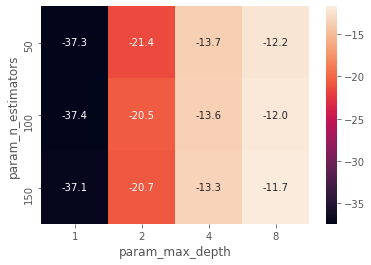

In [123]:
sns.heatmap(pd.DataFrame(grid.cv_results_).pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
), annot=True, fmt='.1f')

# Classification

## Load data

sepal length in cm

sepal width in cm

petal length in cm

petal width in cm

class:
Iris-Setosa

Iris-Versicolour

Iris-Virginica

In [124]:
X = pd.DataFrame(load_iris()['data'])
y = pd.DataFrame(load_iris()['target'])

X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y.columns = ['class']

iris = pd.concat([X, y], axis=1)

X = X.values
y = y.values.ravel()

In [125]:
iris.shape

(150, 5)

In [126]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [202]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 4)
(150,)
(90, 4)
(60, 4)
(90,)
(60,)


## EDA

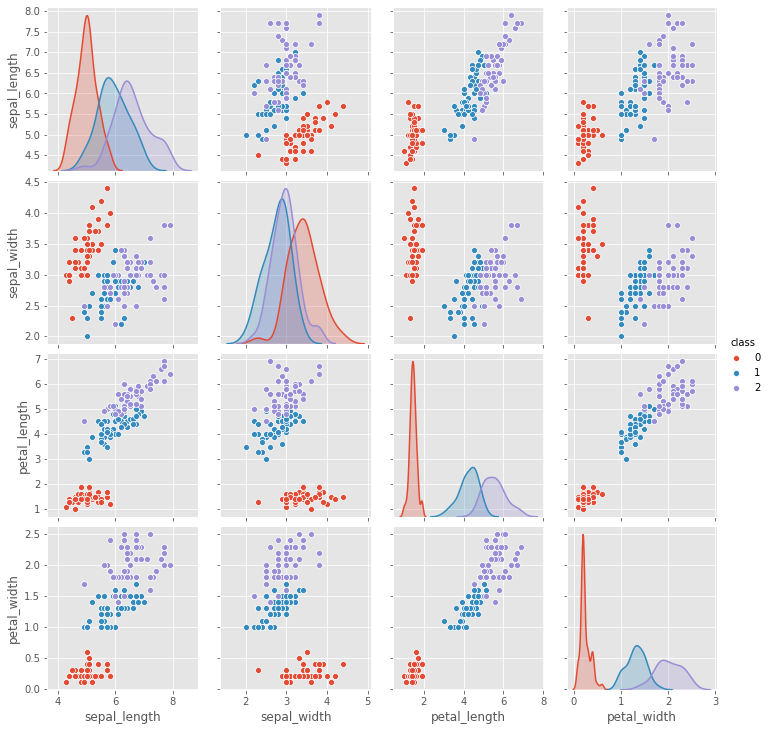

In [128]:
sns.pairplot(iris, hue='class')

## Modelling

In [203]:
logreg = LogisticRegression(C=1e5, solver='liblinear')

In [204]:
np.mean(
    cross_val_score(logreg, X, y, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3))
)

0.96

In [205]:
logreg.fit(X_train, y_train)

confusion_matrix(y_true=y_test, y_pred=logreg.predict(X_test), normalize='true')

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.13636364, 0.86363636]])

Another model

In [206]:
dt = DecisionTreeClassifier()

In [207]:
np.mean(
    cross_val_score(dt, X, y, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3))
)

0.9733333333333333

In [208]:
dt.fit(X_train, y_train)

confusion_matrix(y_true=y_test, y_pred=dt.predict(X_test), normalize='true')

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.09090909, 0.90909091]])

Better. Let's visualise the decision tree!

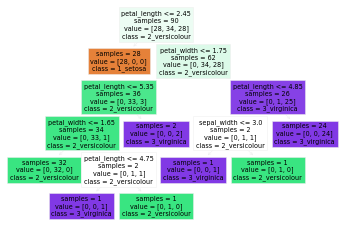

In [210]:
from sklearn.tree import plot_tree

plot_tree(dt, feature_names=iris.drop('class', axis=1).columns,
          class_names=['1_setosa', '2_versicolour', '3_virginica'],
          impurity=False, filled=True
);

Another model

In [211]:
rfc = RandomForestClassifier()

In [212]:
np.mean(
    cross_val_score(rfc, X, y, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3))
)

0.96

In [213]:
rfc.fit(X_train, y_train)

confusion_matrix(y_true=y_test, y_pred=rfc.predict(X_test), normalize='true')

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.09090909, 0.90909091]])

In [218]:
params = {
    'n_estimators': [50, 100, 150, 300],
    'max_depth': [1, 2, 4, 8, 20]
}

In [219]:
grid = GridSearchCV(rfc, params, scoring='accuracy', cv=KFold(n_splits=3))

In [220]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 4, 8, 20],
                         'n_estimators': [50, 100, 150, 300]},
             scoring='accuracy')

In [221]:
grid.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=50)

In [224]:
rfc_best = RandomForestClassifier(max_depth=8, n_estimators=50)
rfc_best.fit(X, y)

RandomForestClassifier(max_depth=8, n_estimators=50)

In [225]:
accuracy_score(y_true=y, y_pred=rfc_best.predict(X))

1.0

In [226]:
confusion_matrix(y_true=y, y_pred=rfc_best.predict(X), normalize='true')

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

<AxesSubplot:xlabel='param_max_depth', ylabel='param_n_estimators'>

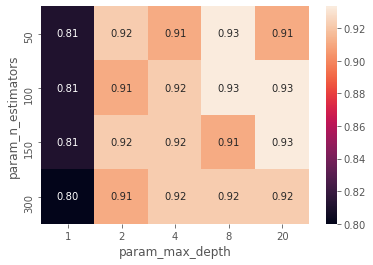

In [233]:
sns.heatmap(pd.DataFrame(grid.cv_results_).pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
), annot=True, fmt='.2f')

In [245]:
pd.DataFrame(
    zip(iris.drop('class', axis=1).columns, rfc_best.feature_importances_),
    columns=['feature','importance']
).sort_values('importance', ascending=False).style.bar(color='#5fba7d')

,feature,importance
3,petal_width,0.434625
2,petal_length,0.417001
0,sepal_length,0.11698
1,sepal_width,0.0313934
